# Function to automatic merge and fill missing values



## Create the function
You have to create a function which take 2 arguments :
- argument 1 : DataFrame main
- argument 2 : DataFrame opinion

Your function will return a new DataFrame which is the left merge of both DataFrames, and which has no missing values (so your function has to fill them), add new columns (flag, MONTH and DAY), and OPINION should be translated.

So you have to copy each useful code from the previous quests, and integrate it into a function. **This should achieve the same results as the previous quests.**

In [6]:
import pandas as pd
link_main = "https://raw.githubusercontent.com/WildCodeSchool/data-training-resources/main/quests/weather_main_2018.csv"
link_opinion = "https://raw.githubusercontent.com/WildCodeSchool/data-training-resources/main/quests/weather_opinion_2018.csv"
df_main = pd.read_csv(link_main)
df_opinion = pd.read_csv(link_opinion)
print(df_main.head())
print(df_opinion.head())

         DATE  MAX_TEMPERATURE_C  MIN_TEMPERATURE_C  WINDSPEED_MAX_KMH  \
0  2018-01-01                 12                  8                 61   
1  2018-01-02                 13                  6                 26   
2  2018-01-03                 15                 10                 40   
3  2018-01-04                 14                 11                 45   
4  2018-01-05                 12                  7                 21   

   TEMPERATURE_MORNING_C  TEMPERATURE_NOON_C  TEMPERATURE_EVENING_C  \
0                      9                  11                      8   
1                      8                  12                     13   
2                     11                  12                     10   
3                     14                  14                     11   
4                     10                  11                      8   

   PRECIP_TOTAL_DAY_MM  HUMIDITY_MAX_PERCENT  VISIBILITY_AVG_KM  \
0                  8.9                    79              9.5

I am allergic to camel case for arguments and variables. sorry not sorry

In [7]:
def translate(opinion: str) -> str:
  match opinion:
    case 'good':
      return 'gut'
    case 'very bad':
      return 'sehr schlecht'
    case 'bad':
      return 'schlecht'
    case 'not good not bad':
      return 'nicht schlecht nicht gut'
    case 'unknown':
      return 'unbekannt'
    case 'very good':
      return 'sehr gut'
    case _:
      return 'unbekannte Meinung'

In [8]:
def add_columns(df):
  df.DATE = pd.to_datetime(df.DATE)
  df['MONTH'] = df.DATE.apply(lambda x: x.month)
  df['DAY'] = df.DATE.apply(lambda x: x.day)
  return df


def translate_opinion(df):
  df['OPINION'] = df['OPINION'].apply(translate)
  return df

def merge_and_fill(df_main, df_opinion):
  new_df = pd.merge(df_main, df_opinion, how='left', left_on='DATE', right_on='date')
  new_df.drop('date', axis = 1, inplace = True)

  # FILL IN MISSING VALUES
  new_df['flag'] = new_df['OPINION'].isna()

  mean_weather_column = new_df.WEATHER_CODE_EVENING.median()
  new_df['WEATHER_CODE_EVENING'].fillna(mean_weather_column, inplace=True)

  total_snow_mm_median = new_df.TOTAL_SNOW_MM.median()
  new_df['TOTAL_SNOW_MM'].fillna(total_snow_mm_median, inplace=True)

  uv_index_median = new_df.UV_INDEX.median()
  new_df['UV_INDEX'].fillna(uv_index_median, inplace=True)

  new_df['SUNHOUR'].fillna(method="ffill", inplace=True)

  new_df['OPINION'].fillna('unknown', inplace=True)

  # ADD NEW COLUMNS
  new_df = add_columns(new_df)


  # TRANSLATE OPINION
  new_df = translate_opinion(new_df)

  return new_df



## Execution with a loop
You will execute your function in a 9 rounds loop, once per year, and agregate this in a new big DataFrame with 24 columns and lots of rows.

In [9]:
# Each year between 2010 and 2018 (included) has 2 sources : weather_main_YYYY.csv and weather_opinion_YYYY.csv

full_df = pd.DataFrame()

for year in range(2010, 2019):
  year = str(year)
  link_main = "https://raw.githubusercontent.com/WildCodeSchool/data-training-resources/main/quests/weather_main_" + year + ".csv"
  link_opinion = "https://raw.githubusercontent.com/WildCodeSchool/data-training-resources/main/quests/weather_opinion_" + year + ".csv"
  df_main = pd.read_csv(link_main)
  df_opinion = pd.read_csv(link_opinion)

  year_df = merge_and_fill(df_main, df_opinion)

  full_df = pd.concat([full_df, year_df])

print(full_df.shape)

(3287, 23)


## Add 2019 to 2022

In [10]:
# Each year since 2019 (included) has 1 source : weatherYYYY.csv
# Chaque année depuis 2019 (inclus) a une seule source avec ce format de nom de fichier : weatherYYYY.csv
link2019 = "https://raw.githubusercontent.com/WildCodeSchool/data-training-resources/main/quests/weather2019.csv"


for year in range(2019, 2023):
  year = str(year)
  link = "https://raw.githubusercontent.com/WildCodeSchool/data-training-resources/main/quests/weather" + year + ".csv"
  df = pd.read_csv(link)


  df = add_columns(df)
  df = translate_opinion(df)

  full_df = pd.concat([full_df, df])

print(f'Shape of final data {full_df.shape}, years = {full_df.shape[0] / 365} (account for leap years)')

Shape of final data (4748, 28), years = 13.008219178082191 (account for leap years)


# Draw a scatterplot
With Date on X-Axis and Max Temperature on Y-axis

The result must have 13 seasonality for the 13 summers/winters alternance.




In [11]:
full_df['DAY_OF_YEAR'] = full_df.apply(lambda x: int(x.DATE.strftime('%j')), axis=1)
full_df['YEAR'] = full_df.apply(lambda x: int(x.DATE.strftime('%Y')), axis=1)

In [18]:
from matplotlib import pyplot as plt
import numpy as np

def draw_scatter_by_specific_x(x: str):
  fig, ax = plt.subplots()

  cmap = plt.get_cmap('tab20', 13)
  colors = cmap(np.linspace(0, 1, 13))

  for year in range(2010, 2023):

    full_df.loc[full_df['YEAR'] == year].plot.scatter(ax=ax, x=x, y='MAX_TEMPERATURE_C', legend=True, color=colors[year - 2010])
    # DATETIME INDEX! pandas datetimeindex()
    plt.xlabel("Date")
    plt.ylabel("Max daily temperature")
  ax.legend(range(2010, 2023));
  ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b'))

  plt.show()

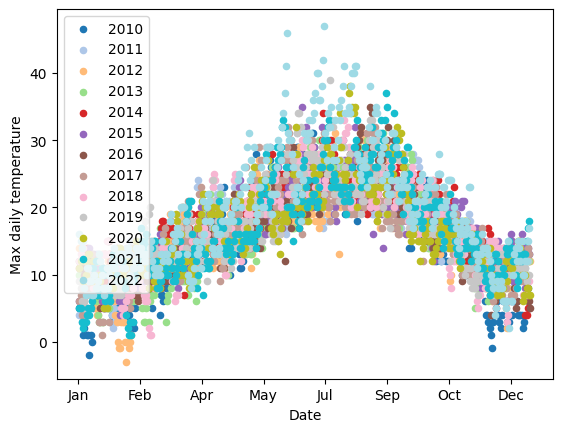

In [19]:
draw_scatter_by_specific_x('DAY_OF_YEAR')

This is barely telling...

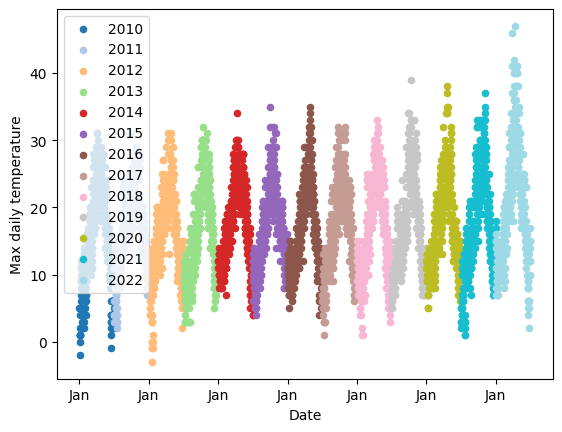

In [20]:
draw_scatter_by_specific_x('DATE')

Awww, much better, apart maybe from fact that here I only can judge for max and min.


Find appropriate dataviz to answer to this question :

Which year had the best weather? Are years very different or not ?


### Let's get us some violins

<Figure size 640x480 with 0 Axes>

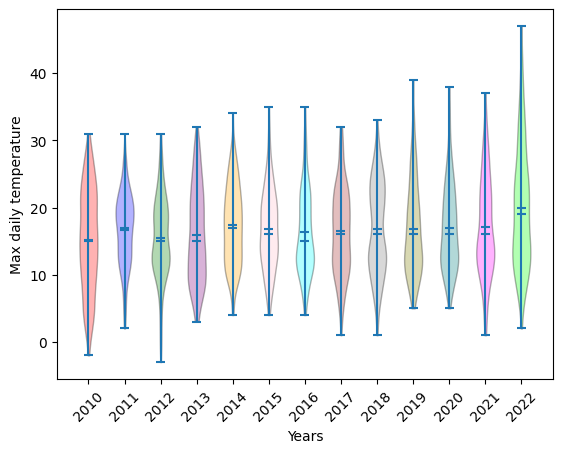

In [21]:
fig = plt.figure()

fig, ax = plt.subplots()

yearly_temps = []
labels = []
colors = ['red', 'blue', 'green', 'purple', 'orange', 'pink', 'cyan', 'brown', 'gray', 'olive', 'teal', 'magenta', 'lime']
for year in range(2010, 2023):
  labels.append(year)
  yearly_temps.append(full_df.loc[full_df['YEAR'] == year].MAX_TEMPERATURE_C)


violins = ax.violinplot(yearly_temps, showmeans=True, showmedians=True)
ax.set_xticks(range(1, 14))
ax.set_xticklabels(labels, rotation=45)

for idx, violin in enumerate(violins['bodies']):
    violin.set_facecolor(colors[idx])
    violin.set_edgecolor('black')

ax.set_xlabel('Years')
ax.set_ylabel('Max daily temperature')

plt.show()

If only temperature is to be considered as a measure of goodness, and if I am considered as a judge on the matter, I'd say, that 2013-2018 years are quite good. Temperature didn't rise above 34, didn't fall below 0.
The bestest, I guess, 2014. It is almost not skimmed to the left or right (top or bottom), median almost the same as the average, days spreaded visibly quite equaly around different temperatures.